# Problem Statement

To build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults and identity-based hate. The dataset used are comments from Wikipedia’s talk page edits.

Google built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

We have extended our neural network model further to prove that this model is able to detect toxicity level and also rightly classify the toxicity level which is not provided by Google's Perspective API. Below is an example of an input test comment "I will kill you" and it has been rightly classified by this model as 95% threat.

We then compared our model outputs with that of Google's Perspective API's model with various input sentences.

We further intend on extending our model to run over twitter comments.

# Approach

The idea is to use the train dataset to train the models with the words in the comments as predictor variables and to predict the probability of toxicity level of a comment. A pre- trained model that gives the best accuracy to various user comments to combat the ongoing issue of online forum abuse. Our project is focused on developing a series of neural network models. The goal is to find the strengths and weakness of different Deep Learning models on the text classification task. We developed 3 specific Neural Network models for this project which are as follows:
1. Convolution Neural Network (CNN with character-level embedding)
2. Convolution Neural Network (CNN with word embedding)
3. Recurrent Neural Network (RNN) with Long Short Term Memory (LSTM) cells
We intend to test the above models trained with the Wikipedia data and word embedding

# Toxic Comment Classification

In this notebook, we'll be developing a Neural Network models that can classify string comments based on their toxicity:
* `toxic`
* `severe_toxic`
* `obscene`
* `threat`
* `insult`
* `identity_hate`

This is a part of the [Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) Kaggle competition. From the site:

>In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

# Import Data
The data we'll be using consists of a large number of Wikipedia comments which have been labeled by humans according to their relative toxicity. The data can be found here. Download the following and store in directory's data folder.

    train.csv - the training set, contains comments with their binary labels.
    test.csv - the test set, predict toxicity probabilities for these comments.
    sample_submission.csv - the submission sample with the correct format.

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [3]:
#function for ploting history of the model training
from pyspark.sql import Row
def plot_history(history_arg):
  array = []
  i =1
  j =1
  for acc in history_arg.history['acc']:
    array.append(Row(epoch=i, accuracy=float(acc)))
    i = i+1
  acc_df = sqlContext.createDataFrame((array))

  array = []
  for loss in history_arg.history['loss']:
      array.append(Row(epoch = j, loss = float(loss)))
      j = j+1
  loss_df = sqlContext.createDataFrame(array)

  display_df = acc_df.join(loss_df,on=("epoch")).orderBy("epoch")
  return display_df

# Explore Data
Extract the features and labels and take a look at sample data.

In [4]:
from pyspark.sql.types import *

#Class labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#Read the data
toxicWordsTrain = pd.read_csv("train.csv");
toxicWordsTest = pd.read_csv("test.csv")

y_train = toxicWordsTrain[list_classes].values
x_train = toxicWordsTrain["comment_text"]
x_test  = toxicWordsTest["comment_text"]

submission = pd.read_csv('sample_submission.csv')

In [5]:
# Sample from dataset
for sample_i in range(3):
    print('Comment #{}:  {}'.format(sample_i + 1, x_train[sample_i]))
    print('Label #{}:    {}'.format(sample_i + 1, y_train[sample_i]))

Comment #1:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label #1:    [0 0 0 0 0 0]
Comment #2:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Label #2:    [0 0 0 0 0 0]
Comment #3:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Label #3:    [0 0 0 0 0 0]


In [6]:
# Explore vocabulary
import collections
from tqdm import tqdm

# Create a counter object for each dataset
word_counter = collections.Counter([word for sentence in tqdm(x_train, total=len(x_train)) \
                                                              for word in sentence.split()])

print('{} words.'.format(len([word for sentence in x_train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

100%|███████████████████████████████████████████████████████████████████████| 159571/159571 [00:02<00:00, 58681.91it/s]


10734904 words.
532299 unique words.
10 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


The dataset contains 10,734,904 words, 532,299 of which are unique, and the 10 most common being: "the", "to", "of", "and", "a", "I", "is", "you", "that", and "in". One problem here is that we are counting uppercase words as different from lower case words and a bunch of other symbols that aren't really useful for our goal. A data cleanup will be done in the next step.

# Preprocessing the data
We preprocess our data a bit so that it's in a format we can input into a neural network. The process includes:

    1. Remove irrelevant characters (!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n).
    2. Convert all letters to lowercase (HeLlO -> hello).
    3. As this is character level embedding, Consider every character as a seperate token. 
    4. Tokenize our words (hi how are you -> [23, 1, 5, 13]).
    5. Standaridize our input length with padding (hi how are you -> [23, 1, 5, 13, 0, 0, 0]).
We can go further and consider combining misspelled, slang, or different word inflections into single base words. However, the benefit of using a neural network is that they do well with raw input, so we'll stick with what we have listed.

In [7]:
# Tokenize and Pad
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=True)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(x_train))
tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index

# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))
print()

# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(x_train[:2], tokenized_train[:2])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

Vocab size: 2335
Longest comment size: 5000
Average comment size: 394.0732213246768
Stdev of comment size: 590.7184309382144
Max comment size: 2166

Sequence 1
  Input:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
  Output: [35, 48, 17, 11, 4, 7, 4, 3, 6, 5, 7, 26, 33, 10, 16, 1, 3, 10, 2, 1, 2, 12, 6, 3, 8, 1, 15, 4, 12, 2, 1, 13, 7, 12, 2, 9, 1, 15, 16, 1, 13, 8, 2, 9, 7, 4, 15, 2, 1, 39, 4, 9, 12, 14, 5, 9, 2, 1, 46, 2, 3, 4, 11, 11, 6, 14, 4, 1, 54, 4, 7, 1, 20, 2, 9, 2, 1, 9, 2, 24, 2, 9, 3, 2, 12, 56, 1, 29, 10, 2, 16, 1, 20, 2, 9, 2, 7, 30, 3, 1, 24, 4, 7, 12, 4, 11, 6, 8, 15, 8, 25, 1, 57, 13, 8, 3, 1, 14, 11, 5, 8, 13, 9, 2, 1, 5, 7, 1, 8, 5, 15, 2, 1, 58, 31, 8, 1, 4, 19, 3, 2, 9, 1, 27, 1, 24, 5, 3, 2, 12, 1, 4, 3, 1, 38, 2, 20, 1, 59, 5, 9, 23, 1, 50, 5, 11

After preprocessing, our vocabulary size drops to a more manageable 210,337 with a max comment size of 371 words and an average comment size of about 68 words per sentence.

# Embedding
The data representation for our vocabulary is one-hot encoding where every word is transformed into a vector with a 1 in its corresponding location. For example, if our word vector is [hi, how, are, you] and the word we are looking at is "you", the input vector for "you" would just be [0, 0, 0, 1]. This works fine unless our vocabulary is huge - in this case, 210,000 - which means we would end up with word vectors that consist mainly of a bunch of 0s.

Instead, we can use a Word2Vec technique to find continuous embeddings for our words. Here, we'll be using the pretrained FastText embeddings from Facebook to produce a 300-dimension vector for each word in our vocabulary.

    P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, Enriching Word Vectors with Subword Information
The benefit of this continuous embedding is that words with similar predictive power will appear closer together on our word vector. The downside is that this creates more of a black box where the words with the most predictive power get lost in the numbers.

In [9]:
embedding_dim = 300

# Get embeddings
embeddings_index = {}
f = open('wiki.en.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 2519371 word vectors.


In [11]:
# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

The above is a lengthy process and hence saving the output to the disk.

In [12]:
# Save embeddings
import h5py
with h5py.File('embeddings.h5', 'w') as hf:
    hf.create_dataset("fasttext",  data=embedding_matrix)

In [13]:
# Load embeddings
with h5py.File('embeddings.h5', 'r') as hf:
    embedding_matrix = hf['fasttext'][:]

# Model
Now that the data is preprocessed and our embeddings are ready, we can build a model. We will build a neural network architecture that is comprises of the following:

    Embedding layer - word vector representations.
    Convolutional layer - run multiple filters over that temporal data.
    Fully connected layer - classify input based on filters.

In [14]:
import keras.backend
from keras.models import Sequential
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam

# Initate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Add Recurrent layers
#model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))

# Add Convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

# Summarize the model
model.summary()


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2166, 300)         700800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2166, 128)         192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 722, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
___________________________________________________________

# Compile the model
We'll be using binary crossentropy as our loss function and clipping our gradients to avoid any explosions.

In [15]:
def loss(y_true, y_pred):
     return keras.backend.binary_crossentropy(y_true, y_pred)

lr = .0001
model.compile(loss=loss, optimizer=Nadam(lr=lr, clipnorm=1.0),
              metrics=['binary_accuracy'])

# Evaluation Metric
To evaluate our model, we'll be looking at its AUC ROC score (area under the receiver operating characteristic curve). We will be looking at the probability that our model ranks a randomly chosen positive instance higher than a randomly chosen negative one. With data that mostly consists of negative labels (no toxicity), our model could just learn to always predict negative and end up with a pretty high accuracy. AUC ROC helps correct this by putting more weight on the the positive examples.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch = 100):
        super(Callback, self).__init__()
        # Initialize state variables
        print("After init")
        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch end 1")
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                print(" - AUC - improved from {:.5f} to {:.5f}".format(self.best, current))
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite=True)
            else:
                print(" - AUC - did not improve")
            
[X, X_val, y, y_val] = train_test_split(processed_X_train, y_train, test_size=0.03, shuffle=False)
RocAuc = RocAucEvaluation(filepath='model.best.hdf5',validation_data=(X_val, y_val), interval=1)

After init


# Train the model
Using a batch size of 64 and set the number of epochs as 1

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss='binary_crossentropy', optimizer='Adam')

# Set variables
batch_size = 64
epochs = 1

# Set early stopping
early_stop = EarlyStopping(monitor="roc_auc_val", mode="max", patience=2)
                                                    
# Train
graph = model.fit(X, y, batch_size=batch_size, epochs=epochs,
                  validation_data=(X_val, y_val), callbacks=[RocAuc, early_stop],
                  verbose=1, shuffle=False)

Train on 154783 samples, validate on 4788 samples
Epoch 1/1
 18496/154783 [==>...........................] - ETA: 6:26:48 - loss: 0.86 - ETA: 5:02:30 - loss: 0.88 - ETA: 4:25:14 - loss: 0.87 - ETA: 4:00:30 - loss: 0.86 - ETA: 3:45:30 - loss: 0.85 - ETA: 3:34:46 - loss: 0.83 - ETA: 3:26:33 - loss: 0.82 - ETA: 3:19:38 - loss: 0.80 - ETA: 3:16:21 - loss: 0.79 - ETA: 3:12:09 - loss: 0.78 - ETA: 3:08:48 - loss: 0.77 - ETA: 3:06:02 - loss: 0.75 - ETA: 3:03:33 - loss: 0.74 - ETA: 3:02:07 - loss: 0.73 - ETA: 3:00:21 - loss: 0.71 - ETA: 2:58:41 - loss: 0.70 - ETA: 2:57:04 - loss: 0.69 - ETA: 2:55:55 - loss: 0.68 - ETA: 2:54:42 - loss: 0.67 - ETA: 2:53:44 - loss: 0.66 - ETA: 2:52:41 - loss: 0.65 - ETA: 2:51:55 - loss: 0.65 - ETA: 2:51:02 - loss: 0.64 - ETA: 2:50:19 - loss: 0.63 - ETA: 2:49:35 - loss: 0.62 - ETA: 2:48:52 - loss: 0.61 - ETA: 2:48:13 - loss: 0.61 - ETA: 2:47:40 - loss: 0.60 - ETA: 2:47:03 - loss: 0.59 - ETA: 2:46:26 - loss: 0.58 - ETA: 2:45:54 - loss: 0.58 - ETA: 2:45:24 - loss: 0.

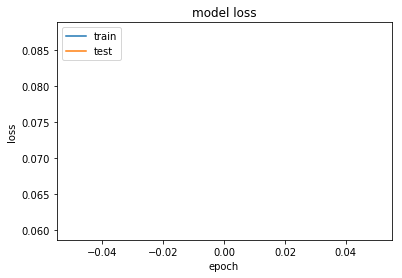

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize history of loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Load best weights and predict

In [19]:
predictions = model.predict(processed_X_test, verbose=0)

### Kaggle competition submission format

In [20]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission[list_classes] = predictions
sample_submission.to_csv("submission3.csv", index=False)

### App prediction
An app pipeline that can be put into production for toxic comment classification. It will take in a string and return the odds that it is any one of the toxic classifications

In [21]:
def toxicity_level(string):
    """
    Return toxicity probability based on inputed string.
    """
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

toxicity_level('go jump off a bridge jerk')
toxicity_level('i will kill you')
toxicity_level('have a nice day')
toxicity_level('hola, como estas')
toxicity_level('hola mierda joder')
toxicity_level('fuck off!!')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         82%
Severe Toxic:  4%
Obscene:       59%
Threat:        0%
Insult:        58%
Identity Hate: 11%

Toxicity levels for 'i will kill you':
Toxic:         75%
Severe Toxic:  11%
Obscene:       37%
Threat:        33%
Insult:        40%
Identity Hate: 15%

Toxicity levels for 'have a nice day':
Toxic:         2%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'hola, como estas':
Toxic:         22%
Severe Toxic:  2%
Obscene:       12%
Threat:        1%
Insult:        7%
Identity Hate: 3%

Toxicity levels for 'hola mierda joder':
Toxic:         25%
Severe Toxic:  0%
Obscene:       6%
Threat:        1%
Insult:        10%
Identity Hate: 2%

Toxicity levels for 'fuck off!!':
Toxic:         100%
Severe Toxic:  23%
Obscene:       99%
Threat:        0%
Insult:        83%
Identity Hate: 2%



From the above sample data, it can be seen that the predictions are not much accurate.
This model is not able to predict the probability as accurate as CNN with word embeddings.
This information is not available on Google's Perspective API model where it can be subcatogerized as a threat.

### Sample test data

In [25]:
toxicity_level('Whats up')

Toxicity levels for 'Whats up':
Toxic:         31%
Severe Toxic:  0%
Obscene:       11%
Threat:        0%
Insult:        9%
Identity Hate: 0%



The same data on Google's Perspective API gives a toxicity level of 5% while the above model give a toxicity level of 31%